In [1]:
import os
import numpy as np
import scipy.io
import pandas as pd
from pathlib import Path

In [2]:
database = pd.DataFrame(columns=['condition', 'name', 'ecg'])

# Create initial empty pandas database

In [3]:
def load_data(path, db):
    directory = Path(path)
    all_files = directory.rglob('*.mat')
    data_list = [i for i in all_files]
    
    # Fetch all file names in database
    
    for item in data_list:
        directory_names = directory.parts
        mat = scipy.io.loadmat(item)
        data = np.squeeze(np.asarray(mat['val']))
        new_row = {'condition':directory_names[8], 'name':os.path.splitext(item.name)[0], 'ecg':data}
        db = db.append(new_row, ignore_index=True)
        
    return db

    # Upload all ECG data from directory to database

filepath = 'C:/Users/Oliver/Documents/FYP/code/database/MLII/'
dirlist = os.listdir(filepath)

for condition in dirlist:  
    database = load_data(filepath + condition, database)
    
# Database details:

# The data contains 1000 ECG signals of size 3600
# There are 17 different heart rhythms in the dataset

# Conditions:

    # 1 NSR = Normal Sinus Rhythm [283 items]
    # 2 APB = Atrial Premature Beat [66 items]
    # 3 AFL = Atrial Flutter [20 items]
    # 4 AFIB = Atrial Fibrilation [135 items]
    # 5 SVTA = Superventricular tachycardia (abnormally fast heart beat above ventricular area) [13 items]
    # 6 WPW = Wolf-Parkinson White Syndrome [21 items]
    # 7 
    
filepath2 = 'C:/Users/Oliver/Documents/FYP/code/database/MLII/'
dirlist2 = os.listdir(filepath)

In [4]:
print(database.head(5))

  condition      name                                                ecg
0     1 NSR  100m (0)  [953, 951, 949, 948, 950, 950, 951, 948, 946, ...
1     1 NSR  100m (1)  [915, 927, 934, 936, 935, 938, 938, 936, 935, ...
2     1 NSR  100m (2)  [989, 984, 981, 981, 983, 987, 984, 982, 982, ...
3     1 NSR  100m (3)  [957, 961, 961, 960, 960, 961, 964, 968, 968, ...
4     1 NSR  100m (4)  [942, 943, 943, 944, 948, 954, 955, 954, 955, ...


In [5]:
import matplotlib.pyplot as plt

def plot_example(case, data, title):
    examples = data[data['condition'] == case]
    example = examples.iloc[1]
    example_ecg = example['ecg']
    
    plt.figure(figsize=(15,4))
    plt.title(title)
    plt.plot(example_ecg)
    plt.show()

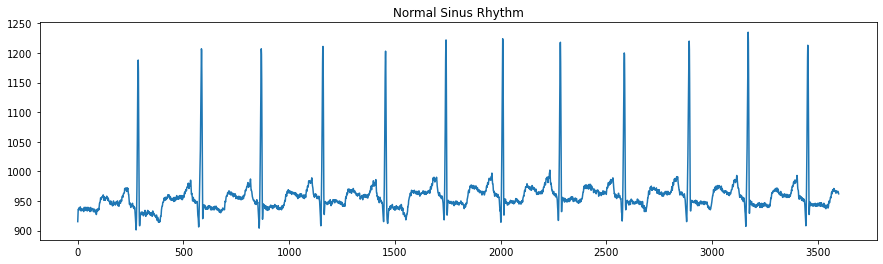

In [6]:
plot_example('1 NSR', database, 'Normal Sinus Rhythm')

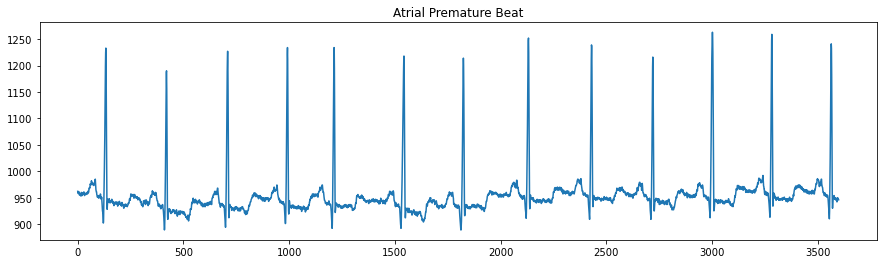

In [7]:
plot_example('2 APB', database, 'Atrial Premature Beat')

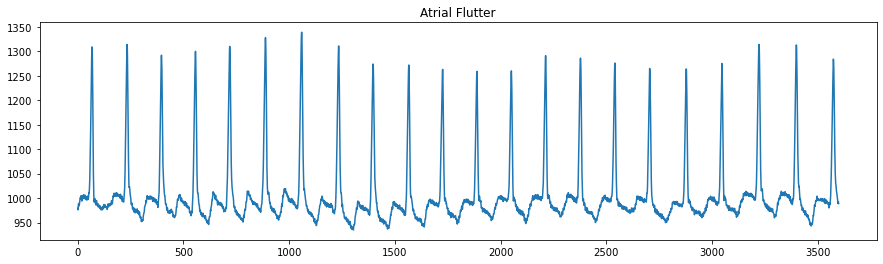

In [8]:
plot_example('3 AFL', database, 'Atrial Flutter')

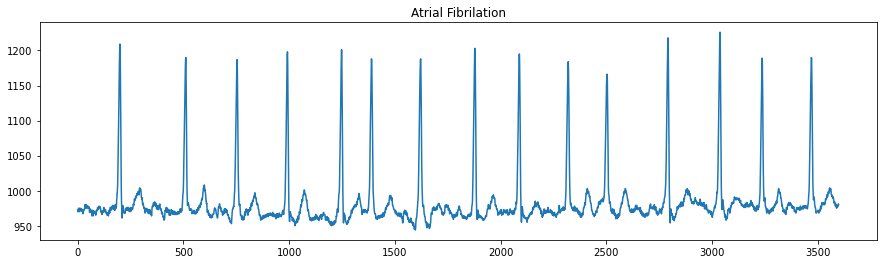

In [9]:
plot_example('4 AFIB', database, 'Atrial Fibrilation')

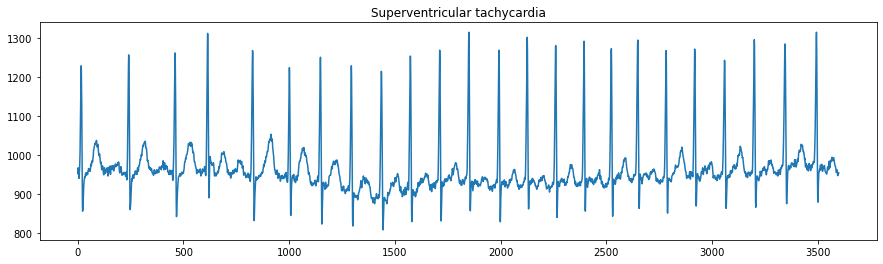

In [10]:
plot_example('5 SVTA', database, 'Superventricular tachycardia')

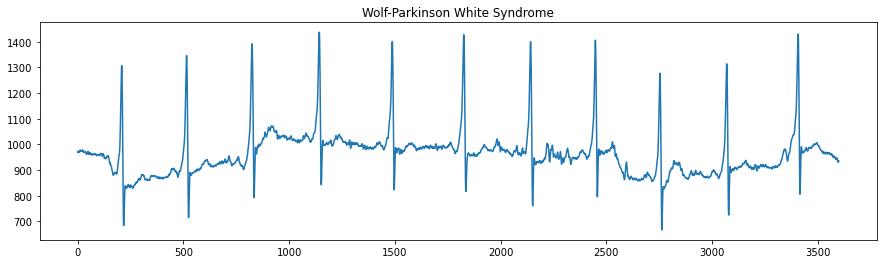

In [11]:
plot_example('6 WPW', database, 'Wolf-Parkinson White Syndrome')

In [12]:
from scipy.signal import lfilter, filtfilt

# DC Notch filter to remove baseline noise

def dc_filt(sig):
    b = [1, -1];
    a = [1, -0.99];
    filt = filtfilt(b, a, sig);
    return filt

In [13]:
ecg_waves = database['ecg'].tolist()
ecg_filt = []

for wave in ecg_waves:
    filt = dc_filt(wave)
    ecg_filt.append(filt)

database['ecg'] = pd.Series(ecg_filt)

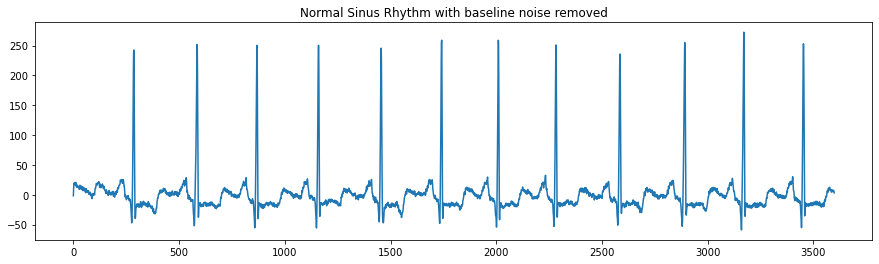

In [14]:
plot_example('1 NSR', database, 'Normal Sinus Rhythm with baseline noise removed')

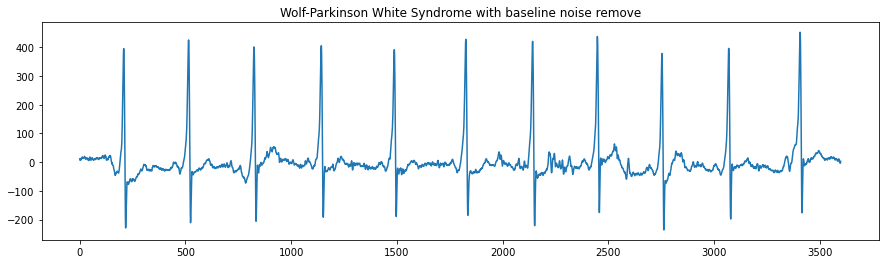

In [15]:
plot_example('6 WPW', database, 'Wolf-Parkinson White Syndrome with baseline noise remove')

In [16]:
def dtw(x, y):
    #Calculate a dynamic distance matrix
    distmat = np.zeros((len(x), len(y)))
    for i in range(0, len(x)):
        for j in range(0, len(y)):
            #Algorithm fills the matrix by calculating the dynamic distance between i and j
            if i == 0:
                min_val = distmat[0, j - 1]
            elif j == 0:
                min_val = distmat[i - 1, 0]
            elif (i and j) == 0:
                min_val = distmat[0, 0]
            else:
                min_val = min(distmat[i - 1, j - 1],
                              distmat[i - 1, j],
                              distmat[i, j - 1])
                
            distmat[i, j] = abs(x[i] - y[j]) + min_val
    
    path = []
    position = []
    
    i = len(x) - 1
    j = len(y) - 1
    path.append(distmat[-1, -1])
    position.append([i, j])
    
    while (i or j) >= 0:
        conditions = np.zeros(3)
        conditions = ([distmat[i - 1, j - 1],
                       distmat[i - 1, j],
                       distmat[i, j - 1]])
    
        nextvalue = np.amin(conditions)
        path.append(nextvalue)
        condition = np.where(conditions == np.amin(conditions))
        cond = condition[0]
        if np.any(condition[0] == 0) == True:
            i = i - 1
            j = j - 1
        elif np.any(condition[0] == 1) == True:
            i = i - 1
        elif np.any(condition[0] == 2) == True:
            j = j - 1
        position.append([i, j])
        
    return distmat, (np.asarray(path), np.asarray(position))

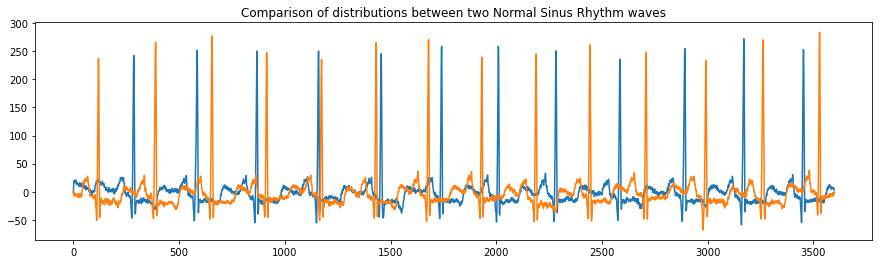

In [17]:
import seaborn as sns

examples = database[database['condition'] == '1 NSR']

example1 = examples.iloc[1]
example2 = examples.iloc[2]

ecg1 = example1['ecg']
ecg2 = example2['ecg']

plt.figure(figsize=(15,4))
plt.plot(ecg1)
plt.plot(ecg2)
plt.title('Comparison of distributions between two Normal Sinus Rhythm waves')
plt.show()

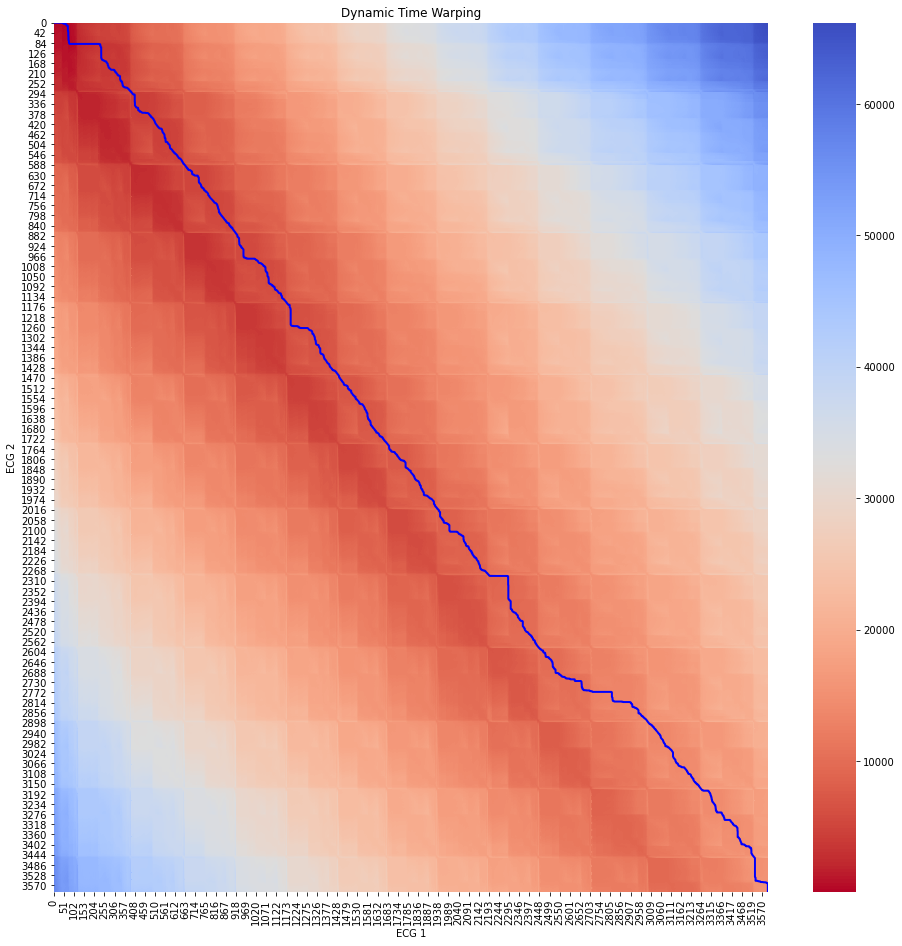

In [20]:
cost_matrix, path = dtw(ecg1, ecg2)

plt.figure(figsize=(16, 16))
ax = plt.axes()
sns.heatmap(cost_matrix, cmap='coolwarm_r', ax=ax)
ax.set_title("Dynamic Time Warping")
ax.set(xlabel='ECG 1', ylabel='ECG 2')

positions = path[1]
a = positions[:,1]
b = positions[:,0]
ax.plot(a + 0.5, b + 0.5, color='blue', linewidth=2)

In [ ]:
from pywt import wavedec

ecg_waves = database['ecg'].tolist()

coeff1 = []
coeff2 = []
coeff3 = []
coeff4 = []

for wave in ecg_waves:
    coeffs = wavedec(wave, 'db1', level=4)
    coeff1.append(coeffs[0])
    coeff2.append(coeffs[1])
    coeff3.append(coeffs[2])
    coeff4.append(coeffs[3])

database['coefficient 1'] = coeff1
database['coefficient 2'] = coeff2
database['coefficient 3'] = coeff3
database['coefficient 4'] = coeff4
# Multilevel discrete decomposition of ECG waves for compression and noise reduction.

In [ ]:
examples = database[database['condition'] == '1 NSR']

example1 = examples.iloc[1]

examples2 = database[database['condition'] == '3 AFL']

example2 = examples2.iloc[2]

plt.figure(figsize=(15,4))
plt.title('Extraction of QRS complex using Level 4 Discrete Wavelet Transform: Normal Sinus Rhythm')
plt.plot(example1['ecg'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 1')
plt.plot(example1['coefficient 1'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 2')
plt.plot(example1['coefficient 2'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 3')
plt.plot(example1['coefficient 3'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 4')
plt.plot(example1['coefficient 4'])
plt.show()

c1 = example1['coefficient 4']

In [ ]:
plt.figure(figsize=(15,4))
plt.title('Extraction of QRS complex using Level 4 Discrete Wavelet Transform: Atrial Flutter')
plt.plot(example2['ecg'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 1')
plt.plot(example2['coefficient 1'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 2')
plt.plot(example2['coefficient 2'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 3')
plt.plot(example2['coefficient 3'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 4')
plt.plot(example2['coefficient 4'])
plt.show()

plt.figure(figsize=(15,4))
plt.title('Coefficient 4')
plt.plot(example1['coefficient 4'])
plt.show()

In [ ]:
from scipy.signal import savgol_filter, find_peaks

peaks, position = find_peaks(c1, height=25)

plt.figure(figsize=(15,4))
plt.title('QRS peak detection of NSR signal')
plt.plot(c1)
plt.plot(peaks, c1[peaks], "x")
plt.plot(np.ones_like(c1) * 25, "--", color="gray")
plt.show()

print(peaks, position) 

In [ ]:
def midpoint(x1, y1, x2, y2):
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    return x, y

In [ ]:
midpoints_x = np.ones(len(peaks) - 1, dtype=float)
midpoints_y = np.ones(len(peaks) - 1, dtype=float)

pos = position['peak_heights']
for i, peak in enumerate(peaks):
    if i > 10:
        break
        
    x1 = peaks[i]
    x2 = peaks[i + 1]
    y1 = pos[i]
    y2 = pos[i + 1]
    x, y = midpoint(x1, y1, x2, y2)
    midpoints_x[i] = x
    midpoints_y[i] = y
    
    
print(midpoints_x, midpoints_y)

plt.figure(figsize=(15,4))
plt.title('Optimal window detection of NSR signal')
plt.plot(c1)
for xv in midpoints_x:
    plt.axvline(x=xv, color='black', linestyle='--')
plt.show()

In [ ]:
mp = np.rint(midpoints_x)
mp = mp.astype(int)

for i, point in enumerate(mp):
    plt.title("Separation " + str(i + 1) + " of extracted feature")
    
    if i == 0:
        plt.plot(c1[0:mp[i]])
        plt.show()
    
    else:
        plt.plot(c1[mp[i - 1]:mp[i]])
        plt.show()
    

In [ ]:
#TODO

#Methodize the peak extraction/optimal window algorithm
#Try for multiple types of ECG
#Create a matrix stacking all separated features on top of each other
#PCA